In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

In [2]:
I = np.eye(2)


Z = np.array([[1,  0],
              [0, -1]])

X = np.array([[0,  1],
              [1,  0]])

Y = np.array([[0,  -1j],
              [1j,  0]])

H = 1/2**0.5*np.array([[1,  1],
                       [1, -1]])

CNOT = np.eye(4)
CNOT[-2:, -2:] = X

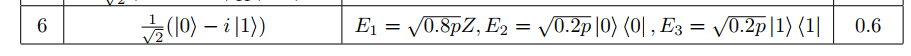

In [3]:
# Гейты, синдромы и кубиты для исправления Z-ошибки
correction_gates = [I, Z, Z, Z]
syndroms = [(0, 0), (0, 1), (1, 0), (1, 1)]
qubits_to_correct = [0, 2, 1, 0]

In [4]:
# Наши операторы Крауса
def E0(p):
    return (1-p)**0.5*I

def E1(p):
    return (0.8*p)**0.5*Z

def E2(p):
    return (0.2*p)**0.5*np.array([[1, 0],
                              [0, 0]])

def E3(p):
    return (0.2*p)**0.5*np.array([[0, 0],
                              [0, 1]])



E = [E0, E1, E2, E3]

In [5]:
# фиделити
def F(r, s):
    return (np.trace(la.sqrtm(la.sqrtm(r)@s@la.sqrtm(r))))**2

In [6]:
# 1-кубитное преобразование
def gate_1d(state, U1, k):
    dim = state.shape[0]
    n = int(np.log2(dim))
    b = np.zeros(dim, dtype=complex)
    mask = 1 << n-1-k
    for ind in range(dim):
        for jk in range(2):
            b[ind] += state[ind - (ind&mask)+(jk << n-1-k)]*U1[int((ind & mask) != 0), jk]
    return b

# 2-кубитное преобразование
def gate_2d(state, U2, l, k): 
    dim = state.shape[0]
    n = int(np.log2(dim))
    b = np.zeros(dim, dtype=complex)
    mask_k, mask_l = (1 << n-1-k) , (1 << n-1-l)
    mask = mask_k + mask_l
    for ind in range(dim):
        for jk in range(2):
            for jl in range(2):
                b[ind] += state[ind - (ind&mask)+(jk << n-1-k)+(jl << n-1-l)]*U2[int((ind & mask_k) != 0) +\
                                                                        (int((ind & mask_l) != 0) << 1), jk+(jl<<1)]
    return b

# 3-кубитное преобразование
def gate_3d(state, U3, p, l, k):
    dim = state.shape[0]
    n = int(np.log2(dim))
    b = np.zeros(dim, dtype=complex)
    mask_k, mask_l, mask_p = (1 << n-1-k) , (1 << n-1-l), (1 << n-1-p)
    mask = mask_k + mask_l + mask_p
    for ind in range(dim):
        for jk in range(2):
            for jl in range(2):
                for jp in range(2):
                    b[ind] += state[ind-(ind&mask)+(jk<<n-1-k)+(jl<<n-1-l)+(jp<<n-1-p)]*U3[int((ind & mask_k) != 0) +\
                                                                                 (int((ind & mask_l) != 0)<<1) +\
                                                                                 (int((ind & mask_p) != 0)<<2), jk+(jl<<1)+(jp<<2)]
    return b

In [7]:
# Состояние в результате кокретного исхода измерения подсистемы (ненормированная ВФ)
def measure(bit3, bit4, psi):
    psi_out = np.kron(np.eye(2**3), np.kron(np.roll(zero_state, bit3), np.roll(zero_state, bit4))) @ psi 
    return psi_out 

In [8]:
# Кодирование состояния
def encode_state(psi):
    psi = gate_2d(psi, CNOT, 0, 1)
    psi = gate_2d(psi, CNOT, 0, 2)
    psi = gate_1d(psi, H, 0)
    psi = gate_1d(psi, H, 1)
    psi = gate_1d(psi, H, 2)

    return psi 

# Выполнение схемы для детектирования ошибки. Z-ошибка применяется к кубиту iz
def run_circuit(psi_, iz=None):    
    if iz!=None:
        psi_ = gate_1d(psi_, Z, iz)
    
    psi_ = gate_1d(psi_, H, 0)
    psi_ = gate_1d(psi_, H, 1)
    psi_ = gate_1d(psi_, H, 2)

    psi_ = gate_2d(psi_, CNOT, 0, 3)
    psi_ = gate_2d(psi_, CNOT, 1, 3)
    psi_ = gate_2d(psi_, CNOT, 0, 4)
    psi_ = gate_2d(psi_, CNOT, 2, 4)

    
    psi_ = gate_1d(psi_, H, 0)
    psi_ = gate_1d(psi_, H, 1)
    psi_ = gate_1d(psi_, H, 2)
    return psi_

# Смешанное состояние после измерения с учетом всех возможных исходов
def get_rho_out(psi_):
# Применяем Z к кубитам, где возникла Z-ошибка, согласно синдромам
    psis = [gate_1d(measure(*syndroms[i], psi_), correction_gates[i], qubits_to_correct[i])\
            for i in range(4)]
# Учитывая все возможные исходы, итог засунем в одну матрицу плотности
    rho_out = np.zeros((2**3, 2**3), dtype=complex)
    for i in range(4):
        rho_out += np.outer(psis[i], np.conj(psis[i]))
    return rho_out

def get_c_out(psi_):
# Применяем Z к кубитам, где возникла Z-ошибка, согласно синдромам
    psis = [gate_1d(measure(*syndroms[i], psi_), correction_gates[i], qubits_to_correct[i])\
            for i in range(4)]
# Учитывая все возможные исходы, итог засунем в одну матрицу плотности
    c_out = np.zeros((4, 2**3), dtype=complex)
    for i in range(4):
        c_out[i] = psis[i]
    return c_out

In [9]:
zero_state = np.zeros(2)
zero_state[0] = 1

psi_in = 1/2**0.5*zero_state - 1j/2**0.5*np.roll(zero_state, 1)
# psi_in = (2/5)**0.5*zero_state- (3j/5)**0.5*np.roll(zero_state, 1)
# Добавим кубиты детектирования ошибки
psi = np.kron(psi_in, np.kron(zero_state, zero_state))

psi_en = encode_state(psi)

psi = np.kron(psi_en, np.kron(zero_state, zero_state))

psi_ = run_circuit(psi)
rho_out = get_rho_out(psi_)

for iz in range(3):
    psi_errz = run_circuit(psi, iz)
    rho_out_errz = get_rho_out(psi_errz)
    print('Z-ошибка на ' + str(iz) + '-м кубите. Фиделити: ' + str(np.round(F(rho_out_errz, rho_out), 2)))

Z-ошибка на 0-м кубите. Фиделити: (1-0j)
Z-ошибка на 1-м кубите. Фиделити: (1-0j)
Z-ошибка на 2-м кубите. Фиделити: (1-0j)


In [10]:
# Посмотрим на работу схемы без Z-ошибки, но с шумами. Будем использовать корневой подход, т.е. создадим матрицу из
# векторов состояний, на которые подействовали все совокупности операторов Краусов
N=40
p_max = 0.7
ps = np.linspace(0, p_max, N)
Fs_corr = np.zeros(N)
Fs_corr_ = np.zeros(N)
for i_p in range(N):
    p = ps[i_p]
    c = np.zeros((4**3, 2**5), dtype=complex)
    for i in range(4):
        for j in range(4):
            for k in range(4):
                c[16*i+4*j+k] = gate_3d(psi, np.kron(E[i](p), np.kron(E[j](p), E[k](p))), 0, 1, 2)

    rho_out_ = np.zeros((2**3, 2**3), dtype=complex)    
    
# К каждому полученному вектору состояния применим детектирование и исправление ошибки. Полученные матрицы
# плотности сложим. Т.к. вектора состояния из c ненормированы, то нормировка итоговой матрицы плотности появится 
# в результате сложения всех полученных матриц плотности

    for psi_ in c:
        psi_ = run_circuit(psi_)
        rho_out_ += get_rho_out(psi_)
        c_out = get_c_out(psi_)
        for i in range(4):
            Fs_corr[i_p] += abs(np.conj(c_out[i])@psi_en)**2
        
    Fs_corr_[i_p] = abs(F(rho_out, rho_out_))

In [11]:
# Посчитаем фиделити без кодов коррекции
Fs = np.zeros(N)
for i_p in range(N):
    p = ps[i_p]
    c = np.zeros((4, 2), dtype=complex)
    for i in range(4):
        c[i] =  E[i](p) @ psi_in
        Fs[i_p] += abs(np.conj(c[i])@psi_in)**2

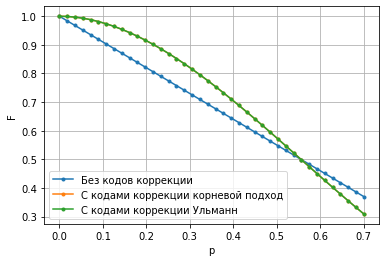

In [12]:
# Изобразим зависимости графически
plt.plot(ps, Fs, '.-',label='Без кодов коррекции')
plt.plot(ps, Fs_corr, '.-', label='С кодами коррекции корневой подход')
plt.plot(ps, Fs_corr_, '.-', label='С кодами коррекции Ульманн')
plt.grid()
plt.xlabel('p')
plt.ylabel('F')
plt.legend()
plt.show()